In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import poligrain as plg
import xarray as xr

from mergeplg import interpolate, merge

In [3]:
# Load processed data, resolution 5 minutes
ds_gauges = xr.open_dataset("./data/openrainer_AWS.nc")
ds_cmls = xr.open_dataset("./data/openrainer_CML.nc")
ds_rad = xr.open_dataset("./data/openrainer_RAD.nc")

# fix CML files
ds_cmls = ds_cmls.reduce(np.nanmean, dim="sublink_id")

# fix RG files
ds_gauges = ds_gauges.rename({"longitude": "lon", "latitude": "lat"})

# fix radar files
ds_rad = ds_rad.rename({"lon": "x", "lat": "y"})
ds_rad = ds_rad.rename({"rainfall_amount": "rainfall_radar"})

ys = [ds_rad.y.values,] * len(ds_rad.x.values)  # fmt: skip
xs = [ds_rad.x.values,] * len(ds_rad.y.values)  # fmt: skip
ds_rad["lat"] = (("y", "x"), np.array(ys).transpose())
ds_rad["lon"] = (("y", "x"), np.array(xs))

ds_rad = ds_rad.set_coords(["lon", "lat"])

In [4]:
# Threshold lower values
radar_zero = 0.01  # here in sum mm over 15 minutes
ds_rad["rainfall_radar"] = xr.where(
    ds_rad.rainfall_radar > radar_zero, ds_rad.rainfall_radar, 0
)

# Project data

In [5]:
# UTM32N: https://epsg.io/32632
ref_str = "EPSG:32632"

In [6]:
ds_gauges.coords["x"], ds_gauges.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauges.lon, ds_gauges.lat, ref_str
)

In [7]:
# For CML
(
    ds_cmls.coords["site_0_x"],
    ds_cmls.coords["site_0_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_0_lon, ds_cmls.site_0_lat, ref_str
)
(
    ds_cmls.coords["site_1_x"],
    ds_cmls.coords["site_1_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_1_lon, ds_cmls.site_1_lat, ref_str
)

# Midpoint
ds_cmls["x"] = (ds_cmls.site_0_x + ds_cmls.site_1_x) / 2
ds_cmls["y"] = (ds_cmls.site_0_y + ds_cmls.site_1_y) / 2

In [8]:
# Projected radar coords
ds_rad.coords["x_grid"], ds_rad.coords["y_grid"] = (
    plg.spatial.project_point_coordinates(ds_rad.lon, ds_rad.lat, ref_str)
)

# Estimate rainfall fields

In [9]:
# Define variogram parameters used by kriging
variogram_parameters = {"sill": 0.9, "range": 30000, "nugget": 0.4}
variogram_model = "exponential"

# Number of neighbours to use for interpolation
nnear = 8

### IDW interpolation

In [10]:
interpolator = interpolate.InterpolateIDW()

rainfall = []
for time in ds_cmls.time.data:
    rainfall.append(
        interpolator.interpolate(
            ds_rad.sel(time=[time]).rainfall_radar,
            da_cml=ds_cmls.sel(time=[time]).R,
            nnear=nnear,
        )
    )
ds_rad["rainfall_interpolateIDW"] = xr.concat(rainfall, dim="time")

### Kriging interpolation

In [11]:
interpolator = interpolate.InterpolateOrdinaryKriging()

rainfall = []
for time in ds_cmls.time.data:
    rainfall.append(
        interpolator.interpolate(
            ds_rad.sel(time=[time]).rainfall_radar,
            da_cml=ds_cmls.sel(time=[time]).R,
            full_line=False,
            variogram_parameters=variogram_parameters,
            nnear=nnear,
        )
    )
ds_rad["rainfall_interpolateBKpoint"] = xr.concat(rainfall, dim="time")

### Block kriging interpolation

In [12]:
interpolator = interpolate.InterpolateOrdinaryKriging()

rainfall = []
for time in ds_cmls.time.data:
    rainfall.append(
        interpolator.interpolate(
            ds_rad.sel(time=[time]).rainfall_radar,
            da_cml=ds_cmls.sel(time=[time]).R,
            full_line=True,
            variogram_parameters=variogram_parameters,
            nnear=nnear,
        )
    )
ds_rad["rainfall_interpolateBKline"] = xr.concat(rainfall, dim="time")

## Adjust radar field

### IDW additive adjust

In [13]:
merger = merge.MergeDifferenceIDW()

rainfall = []
for time in ds_cmls.time.data:
    rainfall.append(
        merger.adjust(
            ds_rad.sel(time=[time]).rainfall_radar,
            da_cml=ds_cmls.sel(time=[time]).R,
            method="additive",
            nnear=nnear,
        )
    )
ds_rad["rainfall_additiveIDW"] = xr.concat(rainfall, dim="time")

### Kriging additive adjust

In [14]:
merger = merge.MergeDifferenceOrdinaryKriging()

rainfall = []
for time in ds_cmls.time.data:
    rainfall.append(
        merger.adjust(
            ds_rad.sel(time=[time]).rainfall_radar,
            da_cml=ds_cmls.sel(time=[time]).R,
            method="additive",
            full_line=False,
            variogram_parameters=variogram_parameters,
            nnear=nnear,
        )
    )
ds_rad["rainfall_additiveBKpoint"] = xr.concat(rainfall, dim="time")

### Block kriging additive adjust

In [15]:
merger = merge.MergeDifferenceOrdinaryKriging()

rainfall = []
for time in ds_cmls.time.data:
    rainfall.append(
        merger.adjust(
            ds_rad.sel(time=[time]).rainfall_radar,
            da_cml=ds_cmls.sel(time=[time]).R,
            method="additive",
            full_line=True,
            variogram_parameters=variogram_parameters,
            nnear=nnear,
        )
    )
ds_rad["rainfall_additiveBKline"] = xr.concat(rainfall, dim="time")

### Block kriging with external drift

In [16]:
merger = merge.MergeKrigingExternalDrift()

rainfall = []
for time in ds_cmls.time.data:
    rainfall.append(
        merger.adjust(
            ds_rad.sel(time=[time]).rainfall_radar,
            da_cml=ds_cmls.sel(time=[time]).R,
            variogram_parameters=variogram_parameters,
            n_closest=nnear,
        )
    )
ds_rad["rainfall_KED"] = xr.concat(rainfall, dim="time")

# Plot rainfall fields

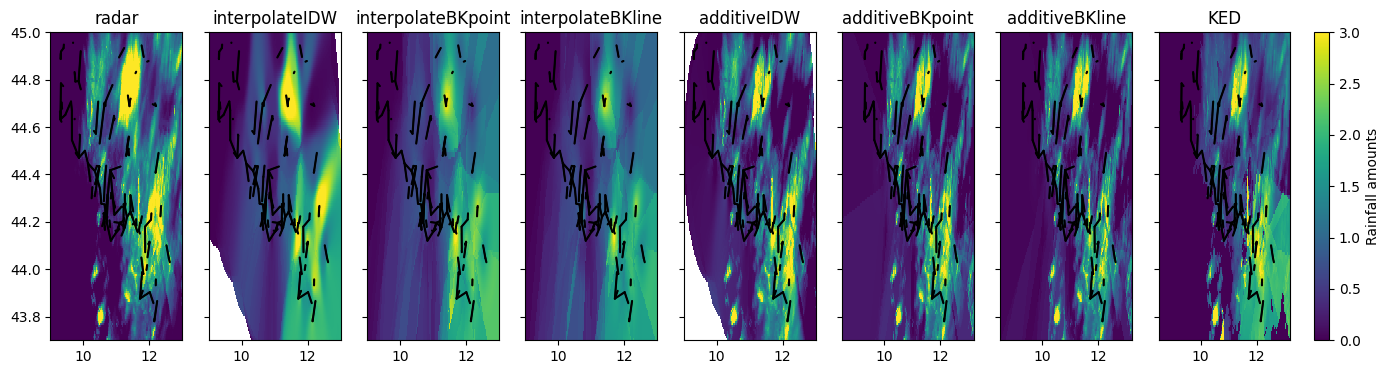

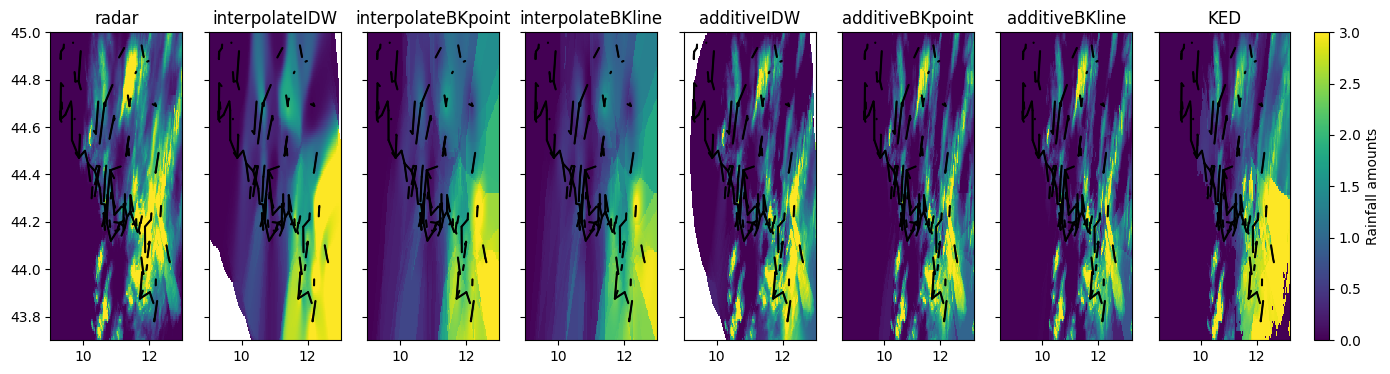

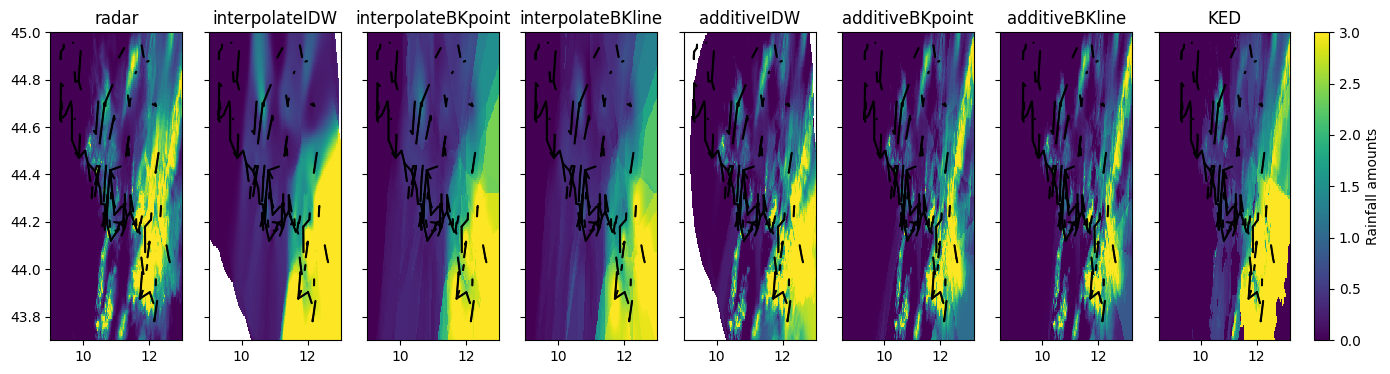

In [17]:
vmax = 3  # max color
cmap_rain = "viridis"
# Time interval to plot
time_start = "2022-09-17T09:45"
time_end = "2022-09-17T10:15"

# Rainfall fields to plot
rainfall_fields = [
    "rainfall_radar",
    "rainfall_interpolateIDW",
    "rainfall_interpolateBKpoint",
    "rainfall_interpolateBKline",
    "rainfall_additiveIDW",
    "rainfall_additiveBKpoint",
    "rainfall_additiveBKline",
    "rainfall_KED",
]

for time in ds_cmls.sel(time=slice(time_start, time_end)).time:
    fig, ax = plt.subplots(1, len(rainfall_fields), figsize=(20, 4), sharey=True)
    for i, rainfall_field in enumerate(rainfall_fields):
        # Plot rainfall field
        im = ax[i].pcolormesh(
            ds_rad.lon,
            ds_rad.lat,
            ds_rad[rainfall_field].sel(time=time),
            vmin=0,
            vmax=vmax,
            cmap=cmap_rain,
        )

        # Plot postion CMLs
        plg.plot_map.plot_lines(
            ds_cmls,
            use_lon_lat=True,
            ax=ax[i],
            line_color="k",
        )

        ax[i].set_title(rainfall_field.split("_")[1])

    for p in range(5):
        ax[p].set_xlim(9, 13)
        ax[p].set_ylim(43.7, 45)

    clb = fig.colorbar(im, ax=ax, location="right", anchor=(-0.25, 1.0))
    clb.ax.set_ylabel("Rainfall amounts")
    plt.show()

# Compare to rain gauges

In [18]:
get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_rad,
    da_point_data=ds_gauges,
    nnear=1,
    stat="best",
)

# Sample rainfall fields
for rainfall_field in rainfall_fields:
    ds_gauges[rainfall_field] = get_grid_at_points(
        da_gridded_data=ds_rad[rainfall_field],
        da_point_data=ds_gauges.rainfall_amount,
    )

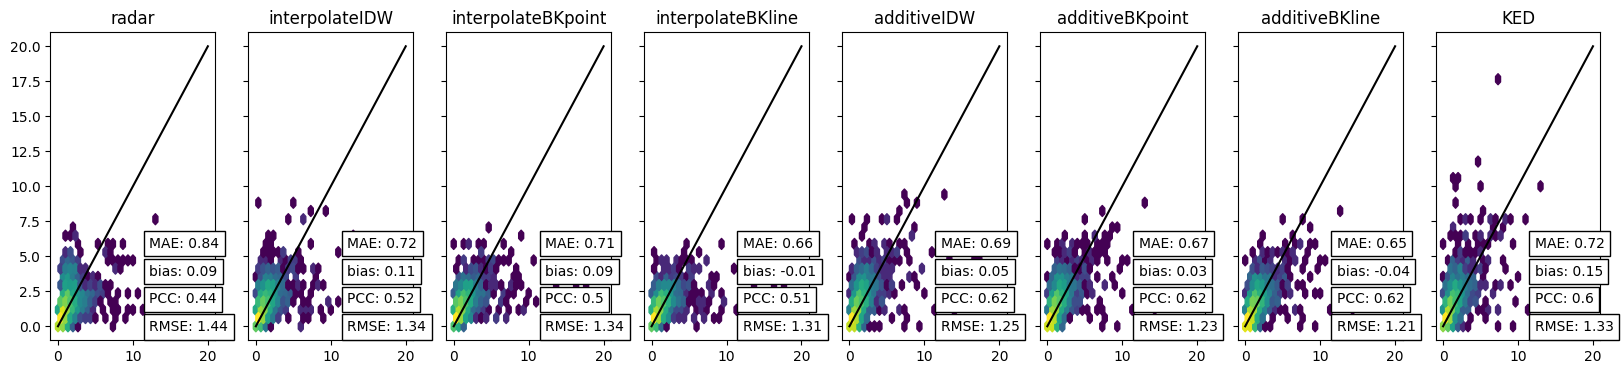

In [19]:
# Plot
vmax = 20
threshold = 0  # Only use above
extent = [0, vmax, 0, vmax]
gridsize = 30

gauge_observed = ds_gauges.rainfall_amount.data.ravel()
fig, ax = plt.subplots(1, len(rainfall_fields), figsize=(20, 4), sharey=True)
for i, rainfall_field in enumerate(rainfall_fields):
    gauge_estimate = ds_gauges[rainfall_field].data.ravel()

    keep = (gauge_observed > 0) & (~np.isnan(gauge_observed))

    ax[i].hexbin(
        gauge_observed[keep],
        gauge_estimate[keep],
        mincnt=1,
        extent=extent,
        gridsize=gridsize,
        bins="log",
    )
    ax[i].text(
        0.6,
        0.03,
        "RMSE: "
        + str(
            round(
                np.sqrt(np.mean((gauge_observed[keep] - gauge_estimate[keep]) ** 2)), 2
            )
        ),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.12,
        "PCC: "
        + str(round(np.corrcoef(gauge_observed[keep], gauge_estimate[keep])[0, 1], 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.21,
        "bias: "
        + str(
            round(
                np.mean(gauge_estimate[keep] - gauge_observed[keep])
                / np.mean(gauge_observed[keep]),
                2,
            )
        ),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.3,
        "MAE: "
        + str(round(np.mean(np.abs(gauge_estimate[keep] - gauge_observed[keep])), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].plot([0, extent[1]], [0, extent[1]], "k")

    ax[i].set_title(rainfall_field.split("_")[1])